In [1]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob
import matplotlib.pyplot as plt

import torch
CLOUD = not torch.cuda.is_available()

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']

In [2]:
# BitsAllocated - remove only one value
# HighBit - remove, same as BitsStored
# BitsStored and PixelRepresentation, - switch to 3 booleans. And WindowCenter_1_NAN + RescaleIntercept = 7 OHE
# ImageOrientationPatient_0, mostly 1, 157 zeros, rest > 0.8. Do it 1 or not 
# ImageOrientationPatient_1 zero or not
# ImageOrientationPatient_2 zero or not
# ImageOrientationPatient_3 zero or not
# ImageOrientationPatient_4 one or not, clip 0.85 to 1, between(0.927184,0.927185), push two special grps to 0.7
# ImageOrientationPatient_5 zero or not, between(-0.374608,-0.374607), two groups to 0.5
# ImagePositionPatient_0 clip -200;-50, -125 category, between(-126.437379,-126.437377)+between(-126.408876,-126.408874)
# groups to -250
# ImagePositionPatient_1 clip -200 to 100, bool for more than -75
# ((train_md.ImagePositionPatient_2 % 0.5) == 0) clip -500,1500
# PixelSpacing_1 between(0.488281,0.488282), clip 0.3;0.7, between(0.494750,0.494864)+between(0.494750,0.494864)
# PixelSpacing_0 duplicate, drop
# WindowCenter_0 group all with less than 1000 app, embedding for 7 groups
# WindowCenter_1 all <1000 cat, NaN cat, and 3 more, - into emb of 5
# pos_inc clip 0,7. 0 and 5 into cats and val -1. 
# pos_inc from other side
# pos_inc [2.0,3.5,4.5] embedding 4 cat
# (((train_md.pos_inc+0.0000001) % 1) < 0.00001).value_counts()
# (((train_md.pos_inc+0.0000001) % 0.001) < 0.00001).value_counts()
# pos_min, pos_max clip -500;500
# pos_size leave as it is, add 10 embedding for the most common
# add pos_idx from tail
# pos_range clip 100,250
# (((train_md.pos_range + 1e-6) % 1) < 1e-3).value_counts()
# pos_zeros all <1000 into one and 4 cat embedding
# pos_inc_rng clip 1,3

# Utility

In [3]:
def myLabelEncoder(data, col, vals, remaining_cat = True):
    name = col+'_le'
    enc_df = pd.DataFrame(np.arange(len(vals)), index=vals, columns = [name])
    data = data.join(enc_df, on=col)

    if remaining_cat:
        data[name] = data[name].fillna(len(vals))
    else:
        assert data[name].isnull().sum() == 0
    
    data[name] = data[name].astype(int).astype('category')
    assert len(data[name].unique()) == (len(vals) + remaining_cat)
    
    return data

In [4]:
def myRoundEncoder(data, col, rounding, postfix):
    name = col+postfix
    data[name] = (((data[col]+0.0000001) % rounding) < 0.00001)
    data[name] = data[name].astype(bool)
    return data

# Prepare metadata

In [5]:
cols_info = ['PatientID','SOPInstanceUID','SeriesInstanceUID','StudyInstanceUID','pos_idx','Rows','Columns']
cols_redundant = ['BitsAllocated','HighBit','WindowCenter_1_NAN','ImageOrientationPatient_0','ImageOrientationPatient_1',
                  'ImageOrientationPatient_2','ImageOrientationPatient_3','PixelSpacing_0','Modality',
                  'PhotometricInterpretation','SamplesPerPixel','StudyID',
                  'ImageOrientationPatient_5_enc_1', # same as ImageOrientationPatient_4_enc_1
                  'PixelSpacing_1_enc_1', # same as ImagePositionPatient_0_enc_1
                 ]
cols_consumed = ['BitsStored','PixelRepresentation','RescaleIntercept','ImageOrientationPatient',
                 'ImageOrientationPatient_4','ImageOrientationPatient_5','ImagePositionPatient',
                 'ImagePositionPatient_0','ImagePositionPatient_1','ImagePositionPatient_2','PixelSpacing',
                 'RescaleSlope','WindowCenter','PixelSpacing_1','WindowCenter_0','WindowCenter_1',
                 'WindowWidth','WindowWidth_0','WindowWidth_1']
cols_float = ['ImageOrientationPatient_4_f','ImageOrientationPatient_5_f','ImagePositionPatient_0_f',
              'ImagePositionPatient_1_f','ImagePositionPatient_2_f','PixelSpacing_1_f',
              'pos_max','pos_min','pos_size','pos_idx1','pos_idx2','pos_inc1','pos_inc2',
              'pos_range','pos_rel','pos_zeros','pos_inc_rng','PxlMin','PxlMax','PxlStd','PxlMean']
cols_bool = ['ImageOrientationPatient_4_enc_0','ImageOrientationPatient_4_enc_1',
             'ImageOrientationPatient_5_enc_0',
             'ImagePositionPatient_0_enc_0','ImagePositionPatient_0_enc_1',
             'ImagePositionPatient_0_f_r1','ImagePositionPatient_0_f_r05','ImagePositionPatient_1_enc_0',
             'ImagePositionPatient_2_f_r05','PixelSpacing_1_enc_0',
             'pos_inc1_r1','pos_inc1_r0001','pos_inc1_enc_0','pos_inc2_enc_0','pos_inc1_enc_1','pos_inc2_enc_1']
cols_le = ['WindowCenter_1_le','BitType_le','WindowCenter_0_le','pos_inc1_grp_le','pos_inc2_grp_le','pos_size_le',
           'pos_zeros_le','WindowWidth_0_le','WindowWidth_1_le','PxlMin_grp_le']

cols_all = cols_redundant + cols_float + cols_bool + cols_le + cols_consumed + cols_info

In [6]:
pickle.dump((cols_le,cols_float,cols_bool), open(PATH_WORK/'covs','wb'))

In [7]:
train_csv = pd.read_csv(PATH/'stage_1_train.csv')

train_csv = train_csv.loc[~train_csv.ID.duplicated()].sort_values('ID').reset_index(drop=True)
all_sop_ids = train_csv.ID.str.split('_').apply(lambda x: x[0]+'_'+x[1]).unique()
train_df = pd.DataFrame(train_csv.Label.values.reshape((-1,6)), columns = all_ich)
train_df['sop_id'] = all_sop_ids

train_df.to_csv(PATH_WORK/'train_df.csv', index=False)

In [11]:
train_md = pd.read_csv(PATH/'train_metadata.csv')
test_md = pd.read_csv(PATH/'test_metadata.csv')
data_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [12]:
data_md.columns = data_md.columns.str.replace('_',' ').str.title().str.replace(' ','').str.replace('Sop','SOP')\
    .str.replace('Uid','UID').str.replace('Id','ID')

In [14]:
for i in range(6):
    data_md['ImageOrientationPatient_{}'.format(i)] \
        = data_md['ImageOrientationPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(3):
    data_md['ImagePositionPatient_{}'.format(i)] \
        = data_md['ImagePositionPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(2):
    data_md['PixelSpacing_{}'.format(i)] \
        = data_md['PixelSpacing'].str.split('\'').apply(lambda x: x[1+2*i])

data_md['WindowCenter_0'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowCenter_1'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md['WindowCenter_1_NAN'] = data_md.WindowCenter_1.isnull()

In [15]:
data_md['ImagePositionPatient_2'] = data_md['ImagePositionPatient_2'].astype(float)
data_md = data_md.sort_values(['SeriesInstanceUID','ImagePositionPatient_2']).reset_index(drop=True)

In [16]:
data_md['WindowWidth_0'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowWidth_1'] \
    = data_md['WindowWidth'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md = myLabelEncoder(data_md, 'WindowWidth_0', [80.0,150.0,100.0,135.0,120.0])

data_md = myLabelEncoder(data_md, 'WindowWidth_1', [80.0,np.nan])

In [17]:
data_md = myLabelEncoder(data_md, 'WindowCenter_1', [36.0,40.0,47.0,np.nan])

In [18]:
data_md['BitType'] = data_md.BitsStored.astype(str) + data_md.PixelRepresentation.astype(str) \
    + data_md.RescaleIntercept.astype(str)

data_md = myLabelEncoder(data_md, 'BitType', ['161-1024.0','120-1024.0','1210.0','1610.0'])

del data_md['BitType']

In [19]:
data_md['ImageOrientationPatient_4_f'] = data_md.ImageOrientationPatient_4.astype(float)

data_md['ImageOrientationPatient_4_enc_0'] = (data_md.ImageOrientationPatient_4_f == 1)
data_md['ImageOrientationPatient_4_enc_1'] = data_md.ImageOrientationPatient_4_f.between(0.927184,0.927185)

data_md['ImageOrientationPatient_4_f'] = np.clip(data_md['ImageOrientationPatient_4_f'].values,0.85,1)

data_md.loc[data_md.ImageOrientationPatient_4_enc_0 | data_md.ImageOrientationPatient_4_enc_1, \
            'ImageOrientationPatient_4_f'] = 0.7

In [20]:
data_md['ImageOrientationPatient_5_f'] = data_md.ImageOrientationPatient_5.astype(float)

data_md['ImageOrientationPatient_5_enc_0'] = (data_md.ImageOrientationPatient_5_f == 0)
data_md['ImageOrientationPatient_5_enc_1'] = data_md.ImageOrientationPatient_5_f.between(-0.374608,-0.374607)

data_md.loc[data_md.ImageOrientationPatient_5_enc_0 | data_md.ImageOrientationPatient_5_enc_1, \
            'ImageOrientationPatient_5_f'] = -0.6

data_md['ImageOrientationPatient_5_f'] = np.clip(data_md['ImageOrientationPatient_5_f'].values,-0.7,0)

In [21]:
data_md['ImagePositionPatient_0_f'] = data_md.ImagePositionPatient_0.astype(float)

data_md['ImagePositionPatient_0_enc_0'] = (data_md.ImagePositionPatient_0_f == -125)
data_md['ImagePositionPatient_0_enc_1'] = (data_md.ImagePositionPatient_0_f.between(-126.437379,-126.437377) |
                                           data_md.ImagePositionPatient_0_f.between(-126.408876,-126.408874))

data_md['ImagePositionPatient_0_f'] = np.clip(data_md['ImagePositionPatient_0_f'].values,-175,-50)

data_md.loc[data_md.ImagePositionPatient_0_enc_0 | data_md.ImagePositionPatient_0_enc_1, \
            'ImagePositionPatient_0_f'] = -200

In [22]:
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 1, '_r1')
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_0_f', 0.5, '_r05')

In [23]:
data_md['ImagePositionPatient_1_f'] = data_md.ImagePositionPatient_1.astype(float)
data_md['ImagePositionPatient_1_f'] = np.clip(data_md['ImagePositionPatient_1_f'].values,-200,100)
data_md['ImagePositionPatient_1_enc_0'] = (data_md['ImagePositionPatient_1_f'] > -75)

In [24]:
data_md['ImagePositionPatient_2_f'] = data_md.ImagePositionPatient_2.astype(float)
data_md = myRoundEncoder(data_md, 'ImagePositionPatient_2_f', 0.5, '_r05')

In [25]:
data_md['PixelSpacing_1_f'] = data_md.PixelSpacing_1.astype(float)

data_md['PixelSpacing_1_enc_0'] = (data_md.PixelSpacing_1_f.between(0.488281,0.488282))
data_md['PixelSpacing_1_enc_1'] = (data_md.PixelSpacing_1_f.between(0.494750,0.494864))

data_md['PixelSpacing_1_f'] = np.clip(data_md['PixelSpacing_1_f'].values,0.3,0.7)

data_md.loc[data_md.PixelSpacing_1_enc_0 | data_md.PixelSpacing_1_enc_1, 'PixelSpacing_1_f'] = 0.2

In [26]:
data_md = myLabelEncoder(data_md, 'WindowCenter_0', [30.0,36.0,40.0,35.0,47.0,50.0])

In [27]:
data_md['pos_max'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: max(x))
data_md['pos_min'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: min(x))
data_md['pos_size'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: len(x))

In [28]:
data_md['pos_idx1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x)))
data_md['pos_idx'] = data_md['pos_idx1']

In [29]:
data_md['pos_idx2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.arange(len(x))[::-1])

In [30]:
data_md['pos_inc1'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([[0],np.diff(x.values)]))
data_md['pos_inc2'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.concatenate([np.diff(x.values),[0]]))

In [31]:
data_md['pos_inc1_grp'] = pd.cut(data_md.pos_inc1, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc1_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc1_grp']

data_md['pos_inc2_grp'] = pd.cut(data_md.pos_inc2, [-1,2.0,3.5,4.5,1000], labels=np.arange(4))
data_md = myLabelEncoder(data_md, 'pos_inc2_grp', [0,1,2,3], remaining_cat=False)

del data_md['pos_inc2_grp']

In [32]:
data_md = myRoundEncoder(data_md, 'pos_inc1', 1, '_r1')
data_md = myRoundEncoder(data_md, 'pos_inc1', 0.001, '_r0001')

In [33]:
data_md['pos_inc1_enc_0'] = (data_md.pos_inc1 == 0)
data_md['pos_inc2_enc_0'] = (data_md.pos_inc2 == 0)
data_md['pos_inc1_enc_1'] = (data_md.pos_inc1 == 5)
data_md['pos_inc2_enc_1'] = (data_md.pos_inc2 == 5)

data_md['pos_inc1'] = np.clip(data_md['pos_inc1'].values,0,7)
data_md['pos_inc2'] = np.clip(data_md['pos_inc2'].values,0,7)

data_md.loc[data_md.pos_inc1_enc_0 | data_md.pos_inc1_enc_1, 'pos_inc1'] = -1
data_md.loc[data_md.pos_inc2_enc_0 | data_md.pos_inc2_enc_1, 'pos_inc2'] = -1

In [34]:
data_md = myLabelEncoder(data_md, 'pos_size', [32,40,36,28,34,30,35,33,38,44])

In [35]:
data_md['pos_range'] = (data_md['pos_max'] - data_md['pos_min'])
data_md['pos_rel'] = ((data_md['ImagePositionPatient_2'] - data_md['pos_min'])/data_md['pos_range'])\
    .where(data_md['pos_range'] > 0, 0.5)

data_md['pos_zeros'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: (np.diff(x.values) <= 0.001).sum())

data_md['pos_inc_rng'] = data_md[['SeriesInstanceUID','ImagePositionPatient_2']]\
    .groupby('SeriesInstanceUID').transform(lambda x: np.diff(x.values)[np.diff(x.values) > 0.1].max() /
                                                      np.diff(x.values)[np.diff(x.values) > 0.1].min())

data_md['pos_inc_rng'] = np.clip(data_md['pos_inc_rng'],0,3)

In [36]:
data_md['pos_min'] = np.clip(data_md['pos_min'].values,-500,500)
data_md['pos_max'] = np.clip(data_md['pos_max'].values,-500,500)

In [37]:
data_md['pos_range'] = np.clip(data_md['pos_range'].values,100,250)

data_md = myLabelEncoder(data_md, 'pos_zeros', [0,4,8])

In [38]:
data_md['PxlStd'] = np.clip(data_md['PxlStd'].values,0,1500)
data_md['PxlMean'] = np.clip(data_md['PxlMean'].values,-1900,-100)
data_md['PxlMin'] = np.clip(data_md['PxlMin'].values,-3500,-1000)
data_md['PxlMax'] = np.clip(data_md['PxlMax'].values,-1000,3500)

In [39]:
data_md['PxlMin_grp'] = pd.cut(data_md.PxlMin, [-5000,-2500,-1500,2000], labels=np.arange(3))
data_md = myLabelEncoder(data_md, 'PxlMin_grp', [0,1,2], remaining_cat=False)
del data_md['PxlMin_grp']

In [40]:
assert len([col for col in cols_all if col not in data_md.columns]) == 0
assert len([col for col in data_md.columns if col not in (cols_all + all_ich)]) == 0

In [41]:
data_md = data_md.join(train_df.set_index('sop_id'), on = 'SOPInstanceUID')

In [42]:
assert data_md['any'].isnull().sum() == 78545
assert (~data_md['any'].isnull()).sum() == 674257

In [43]:
for col in (cols_float + cols_bool):
    data_md[col] = data_md[col].astype(float)

#for col in cols_cat:
#    data_md[col] = pd.factorize(data_md[col])[0]
#    data_md[col] = data_md[col].astype('category')

In [44]:
M = 4
data_md['ImageOrientationPatient_4_f'] = M*(data_md['ImageOrientationPatient_4_f'] - 0.8)/0.3
data_md['ImageOrientationPatient_5_f'] = M*(data_md['ImageOrientationPatient_5_f'] + 0.5)/0.6
data_md['ImagePositionPatient_0_f'] =    M*(data_md['ImagePositionPatient_0_f'] + 173)/150
data_md['ImagePositionPatient_1_f'] =    M*(data_md['ImagePositionPatient_1_f'] + 65)/300
data_md['ImagePositionPatient_2_f'] =    M*(data_md['ImagePositionPatient_2_f'] - 167)/2792
data_md['PixelSpacing_1_f'] =            M*(data_md['PixelSpacing_1_f'] - 0.26)/0.5
data_md['pos_max'] =                     M*(data_md['pos_max'])/1000
data_md['pos_min'] =                     M*(data_md['pos_min'])/1000
data_md['pos_size'] =                    M*(data_md['pos_size'] - 35)/40
data_md['pos_idx1'] =                    M*(data_md['pos_idx1'] - 17)/59
data_md['pos_idx2'] =                    M*(data_md['pos_idx2'] - 17)/59
data_md['pos_inc1'] =                    M*(data_md['pos_inc1'] - 2)/8
data_md['pos_inc2'] =                    M*(data_md['pos_inc2'] - 2)/8
data_md['pos_range'] =                   M*(data_md['pos_range'] - 165)/150
data_md['pos_rel'] =                     M*(data_md['pos_rel'] - 0.5)/1.0
data_md['pos_zeros'] =                   M*(data_md['pos_zeros'])/10
data_md['pos_inc_rng'] =                 M*(data_md['pos_inc_rng'] - 1.3)/2.0

data_md['PxlMin'] =                      M*(data_md['PxlMin'] + 2000)/3000
data_md['PxlMax'] =                      M*(data_md['PxlMax'] - 1500)/3000
data_md['PxlMean'] =                     M*(data_md['PxlMean'] + 800)/1000
data_md['PxlStd'] =                      M*(data_md['PxlStd'] - 800)/1000

In [45]:
data_md.to_csv(PATH_WORK/'data_md.csv', index=False)

In [46]:
train_md = data_md.loc[~data_md['any'].isnull()].copy().reset_index(drop=True)
for col in all_ich:
    train_md[col] = train_md[col].astype(int)
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)

test_md = data_md.loc[data_md['any'].isnull()].copy().reset_index(drop=True)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

In [47]:
data_md = pd.read_csv(PATH_WORK/'data_md.csv')

In [48]:
test_md = pd.read_csv(PATH_WORK/'test_md.csv')
train_md = pd.read_csv(PATH_WORK/'train_md.csv')

# Analysis

In [49]:
for col in cols_le:
    print(col, len(data_md[col].unique()))

WindowCenter_1_le 5
BitType_le 5
WindowCenter_0_le 7
pos_inc1_grp_le 4
pos_inc2_grp_le 4
pos_size_le 11
pos_zeros_le 4
WindowWidth_0_le 6
WindowWidth_1_le 3
PxlMin_grp_le 3


In [50]:
train_md[cols_float].mean()

ImageOrientationPatient_4_f    0.058563
ImageOrientationPatient_5_f    0.222398
ImagePositionPatient_0_f       0.048668
ImagePositionPatient_1_f       0.066942
ImagePositionPatient_2_f       0.010251
PixelSpacing_1_f               0.069438
pos_max                        0.880705
pos_min                        0.261473
pos_size                       0.024645
pos_idx1                       0.008354
pos_idx2                       0.008354
pos_inc1                       0.030327
pos_inc2                       0.030327
pos_range                      0.013157
pos_rel                       -0.057270
pos_zeros                      0.024279
pos_inc_rng                   -0.080632
PxlMin                         0.236361
PxlMax                         0.149736
PxlStd                        -0.032196
PxlMean                        0.124001
dtype: float64

In [51]:
train_md[cols_float].std()

ImageOrientationPatient_4_f    1.693531
ImageOrientationPatient_5_f    1.159401
ImagePositionPatient_0_f       1.069924
ImagePositionPatient_1_f       0.866594
ImagePositionPatient_2_f       0.367141
PixelSpacing_1_f               0.915759
pos_max                        0.468271
pos_min                        0.581765
pos_size                       0.536172
pos_idx1                       0.720769
pos_idx2                       0.720769
pos_inc1                       1.502420
pos_inc2                       1.502420
pos_range                      0.489795
pos_rel                        1.198624
pos_zeros                      0.361715
pos_inc_rng                    1.106501
PxlMin                         1.222550
PxlMax                         0.713566
PxlStd                         1.243883
PxlMean                        1.049480
dtype: float64

In [52]:
cnts = data_md[['SeriesInstanceUID'] + cols_bool]\
    .groupby('SeriesInstanceUID').agg(lambda x: len(x.unique()))

In [53]:
cnts.sum()/cnts.shape[0]

ImageOrientationPatient_4_enc_0    1.000184
ImageOrientationPatient_4_enc_1    1.000184
ImageOrientationPatient_5_enc_0    1.000184
ImagePositionPatient_0_enc_0       1.000046
ImagePositionPatient_0_enc_1       1.000000
ImagePositionPatient_0_f_r1        1.000046
ImagePositionPatient_0_f_r05       1.000092
ImagePositionPatient_1_enc_0       1.000092
ImagePositionPatient_2_f_r05       1.025570
PixelSpacing_1_enc_0               1.000000
pos_inc1_r1                        1.671036
pos_inc1_r0001                     1.432763
pos_inc1_enc_0                     2.000000
pos_inc2_enc_0                     2.000000
pos_inc1_enc_1                     1.428532
pos_inc2_enc_1                     1.428532
dtype: float64

In [54]:
significant_cols = []

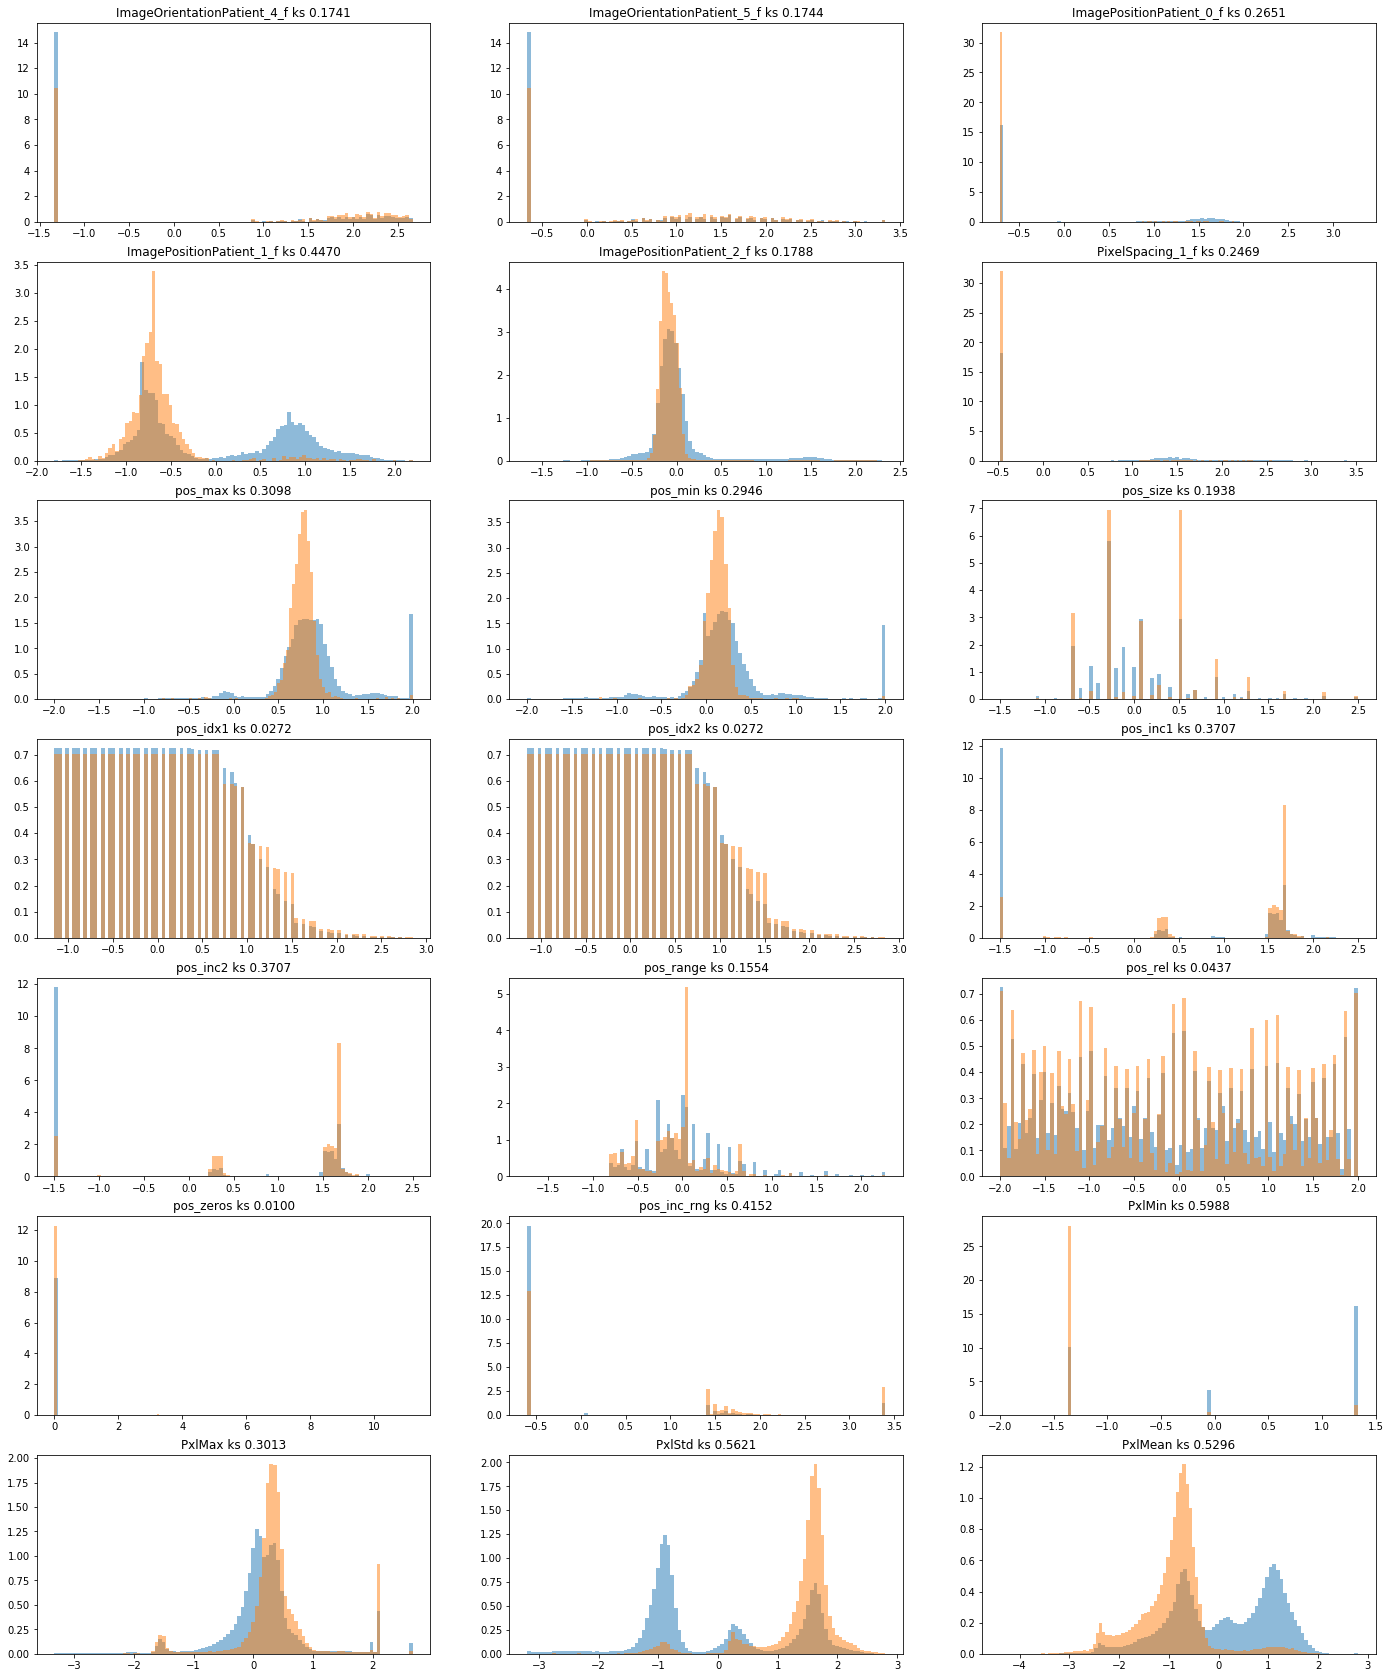

In [55]:
fig, axes = plt.subplots(7, 3, figsize=(24, 30))

for i, ax in enumerate(axes.flatten()):
    if i >= len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

In [56]:
for col in cols_le:
    print(pd.crosstab(data_md[col], data_md['any'].isnull()))

any                 False  True 
WindowCenter_1_le               
0                  248152   2157
1                   70894    985
2                   10377     34
3                  341678  75369
4                    3156      0
any          False  True 
BitType_le               
0           338727  75369
1           323551   3088
2             2252     60
3             2951      0
4             6776     28
any                 False  True 
WindowCenter_0_le               
0                  213404  69272
1                  248152   2157
2                  151196   2148
3                   43652   4934
4                   10343     34
5                    3957      0
6                    3553      0
any               False  True 
pos_inc1_grp_le               
0                 25149   3724
1                 51896  14995
2                  7567    250
3                589645  59576
any               False  True 
pos_inc2_grp_le               
0                 25149   3724
1          

In [57]:
pd.crosstab([data_md.BitsStored, data_md.PixelRepresentation, data_md.RescaleIntercept],
             data_md['any'].isnull())

any                                               False  True 
BitsStored PixelRepresentation RescaleIntercept               
12         0                   -1024.0           323551   3088
                               -1000.0             6653     28
                                0.0                  73      0
                                1.0                  50      0
           1                    0.0                2252     60
16         1                   -1024.0           338727  75369
                                0.0                2951      0

In [58]:
pd.crosstab([train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0],
             train_md['any'])

any,0,1
row_0,,
0.0,536963,96762
1.0,40128,340
2.0,63,1


In [59]:
np.corrcoef(train_md['any'], train_md.pos_inc2_enc_0 + train_md.pos_inc1_enc_0)

array([[ 1.        , -0.09758383],
       [-0.09758383,  1.        ]])

In [60]:
bins = data_md.PxlStd.min() + np.arange(301)*(data_md.PxlStd.max() - data_md.PxlStd.min())/300

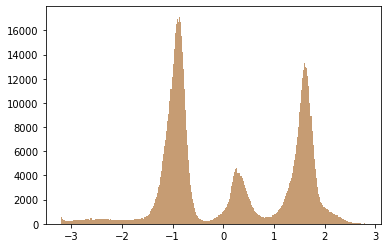

In [61]:
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528')].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin > -1500)].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin < -2500)].PxlStd,
             alpha=0.5,bins=bins)
a = plt.hist(data_md.loc[((data_md.PixelRepresentation != 0) | (data_md.RescaleIntercept < 0)) & 
                         (data_md.SOPInstanceUID != 'ID_b79eed528') & 
                         (data_md.PxlMin.between(-2500,-1500))].PxlStd,
             alpha=0.5,bins=bins)

In [62]:
data_md.loc[data_md.PxlMin < -3450,'any'].isnull().value_counts()

Series([], Name: any, dtype: int64)

# Weighting

In [63]:
weights = np.ones(len(train_md))

In [64]:
data_md['test'] = data_md['any'].isnull()

In [65]:
for col in (cols_le + cols_bool):
    tt = data_md[[col,'test']].groupby(col).sum()
    empty_categories = tt.index.values[tt['test']==0]
    if len(empty_categories) > 0:
        print(col, empty_categories, train_md[col].isin(empty_categories).sum())
        weights[train_md[col].isin(empty_categories)] = 0

WindowCenter_1_le [4] 3156
BitType_le [3] 2951
WindowCenter_0_le [5 6] 7510
WindowWidth_1_le [2] 2981


In [66]:
data_md.loc[~data_md.test, 'weights'] = weights

In [67]:
pd.value_counts(weights)

1.0    663139
0.0     11118
dtype: int64

In [68]:
if ((test_md.PixelRepresentation == 0) & (test_md.RescaleIntercept >= 0)).sum() == 0:
    weights[(train_md.PixelRepresentation == 0) & (train_md.RescaleIntercept >= 0)] = 0

In [69]:
pd.value_counts(weights)

1.0    663016
0.0     11241
dtype: int64

In [70]:
weights[train_md.SOPInstanceUID == 'ID_b79eed528'] = 0

In [71]:
pd.value_counts(weights)

1.0    663015
0.0     11242
dtype: int64

In [72]:
data_filt = data_md.loc[data_md.weights.fillna(-1) != 0]

In [73]:
tt = pd.crosstab(data_filt.PxlMin_grp_le == 0, data_filt['any'].isnull())

In [78]:
tt

any,False,True
PxlMin_grp_le,,
False,438744,5029
True,224395,73516


In [74]:
ww = tt.loc[False,True] * tt.loc[True,False] / (tt.loc[True,True] * tt.loc[False,False])

In [75]:
weights[(train_md.PxlMin_grp_le != 0) & (weights > 0)] = ww

In [76]:
pd.value_counts(weights)

0.034987    438621
1.000000    224394
0.000000     11242
dtype: int64

In [77]:
train_md['weights'] = weights
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)

pickle.dump(weights, open(PATH_WORK/'weights','wb'))